In [ ]:
from os import listdir
import cv2
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lấy data ảnh trên kaggle

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
# Chọn file kaggle.json tải về ở bước 2 để tải lên

!mkdir '/root/.kaggle'
!cp kaggle.json '/root/.kaggle'
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list
# Chạy lệnh liệt kê các bộ dữ liệu của bạn để đảm bảo bạn đã cài đặt thành công

Saving kaggle.json to kaggle.json
ref                                                       title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                     Data Science Salaries 2023 💸                   25KB  2023-04-13 09:55:16          19024        527  1.0              
fatihb/coffee-quality-data-cqi                            Coffee Quality Data (CQI May-2023)             22KB  2023-05-12 13:06:39           1240         42  1.0              
ashpalsingh1525/imdb-movies-dataset                       IMDB movies dataset                             3MB  2023-04-28 23:18:15           2005         45  1.0              
iammustafatz/diabetes-prediction-dataset                  Diabetes prediction dataset 

In [ ]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 72% 34.0M/47.0M [00:00<00:00, 87.5MB/s]
100% 47.0M/47.0M [00:00<00:00, 101MB/s] 


In [ ]:
!unzip -q shoe-vs-sandal-vs-boot-dataset-15k-images.zip

In [ ]:
raw_folder = "/content/Shoe vs Sandal vs Boot Dataset/"

# Tiền xử lý dữ liệu


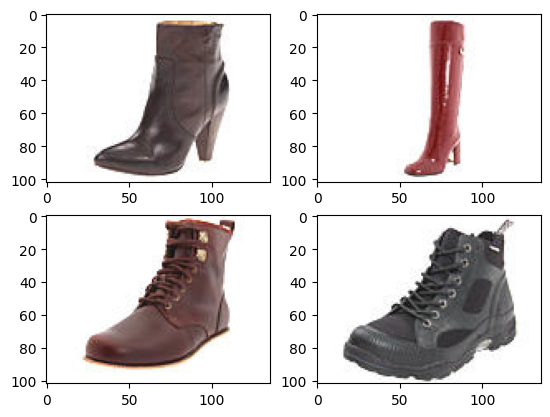

In [ ]:
#kiểm tra thư mục đã unzip
import os
import matplotlib.pyplot as plt
from PIL import Image

#kiem tra data trong thu muc boot

# Đường dẫn tới thư mục chứa ảnh
image_folder = '/content/Shoe vs Sandal vs Boot Dataset/Boot'

# Tải các ảnh vào một list
images = []
for filename in os.listdir(image_folder):
    img = Image.open(os.path.join(image_folder, filename))
    images.append(img)

# Hiển thị 4 ảnh đầu tiên trong list
fig, axs = plt.subplots(nrows=2, ncols=2)
axs[0, 0].imshow(images[0])
axs[0, 1].imshow(images[1])
axs[1, 0].imshow(images[2])
axs[1, 1].imshow(images[3])
plt.show()

#kiem tra so luong anh trong file Sandal
folder = '/content/Shoe vs Sandal vs Boot Dataset/Sandal'
num_files = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
print("Number of files in folder:", num_files)


In [ ]:
#tạo new file để chứa ảnh mới khi đã được thay đổi phù hợp để đưa vào train
import os

new_folder = 'new_folder_path'
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

    

In [ ]:
#hàm resize ảnh để đưa toàn bộ ảnh về 1 kích thước, định dạng RGB về một dạng phù hợp
from PIL import Image
#ảnh nguồn sẽ được thay đổi kích thước sao cho chiều dài hoặc chiều rộng dài nhất sẽ bằng kích thước đích đã cho (bằng cách sử dụng phương pháp thu nhỏ ảnh "thumbnail" của thư viện PIL). Sau đó, hàm tạo một ảnh mới với kích thước đích đã cho và màu nền tương ứng, và dán ảnh thu nhỏ vào giữa ảnh mới. Cuối cùng, hàm trả về ảnh đã được thay đổi kích thước và được căn giữa trên nền ảnh mới.
# function to resize image
def resize_image(src_image, size=(128,128), bg_color="white"): 
    from PIL import Image, ImageOps 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

In [ ]:
#lượt qua toàn bộ các ảnh để áp dụng hàm resize và lưu toàn bộ vào thư mục mới (/content/new_folder_path)
import shutil
training_folder_name = raw_folder

# New location for the resized images
train_folder = '/content/new_folder_path'


# Create resized copies of all of the source images
size = (128,128)

# Create the output folder if it doesn't already exist
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

# Loop through each subfolder in the input folder
print('Transforming images...')
for root, folders, files in os.walk(training_folder_name):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        # Create a matching subfolder in the output dir
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the files in the subfolder
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
            # Open the file
            file_path = os.path.join(root,sub_folder, file_name)
            #print("reading " + file_path)
            image = Image.open(file_path)
            # Create a resized version and save it
            resized_image = resize_image(image, size)
            saveAs = os.path.join(saveFolder, file_name)
            #print("writing " + saveAs)
            resized_image.save(saveAs)

print('Done.')

Transforming images...
processing folder Boot
processing folder Shoe
processing folder Sandal
Done.


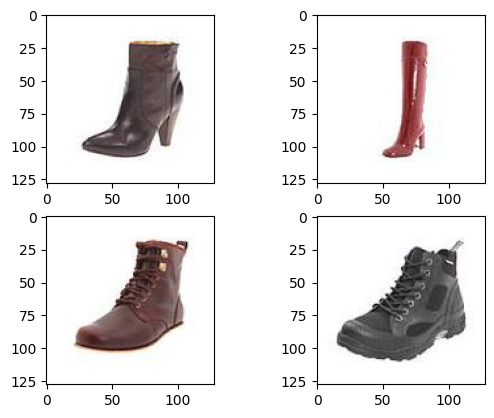

In [ ]:
#hiển thị lại 1 số ảnh trong thư mục mới đã resize
import os
import matplotlib.pyplot as plt
from PIL import Image

# Đường dẫn tới thư mục chứa ảnh
image_folder = '/content/new_folder_path/Boot'

# Tải các ảnh vào một list
images = []
for filename in os.listdir(image_folder):
    img = Image.open(os.path.join(image_folder, filename))
    images.append(img)

# Hiển thị 4 ảnh đầu tiên trong list
fig, axs = plt.subplots(nrows=2, ncols=2)
axs[0, 0].imshow(images[0])
axs[0, 1].imshow(images[1])
axs[1, 0].imshow(images[2])
axs[1, 1].imshow(images[3])
plt.show()
#kiểm tra số lượng ảnh trong BOOT mới
folder = '/content/new_folder_path/Boot'
num_files = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
print("Number of files in folder:", num_files)

In [ ]:
num_worker = os.cpu_count()
num_worker

2

In [ ]:
#áp dụng transforms để làm giàu ảnh, tạo train_dataset, test_dataset từ toàn bộ ảnh đã resize trước đó
from torchvision import datasets, transforms

def load_dataset(train_folder):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    # Load all the images
    transformation = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5), #tạo một biến thể bằng cách lật ngang ngẫu nhiên ảnh với xác suất 0.5.
        transforms.RandomVerticalFlip(0.3), #tạo một biến thể bằng cách lật dọc ngẫu nhiên ảnh với xác suất 0.3.
        #transforms.RandomRotation(30), #quay ảnh một số độ ngẫu nhiên trong khoảng từ -degrees đến degrees.
        #transforms.RandomCrop((100,100)), #cắt ngẫu nhiên một vùng ảnh có kích thước size từ ảnh ban đầu.
        transforms.ColorJitter(), #thay đổi ngẫu nhiên độ sáng, độ tương phản, độ bão hòa màu và độ nhiễu của ảnh.
        transforms.Resize((128,128)),
        transforms.ToTensor(), # chuyển đổi ảnh từ định dạng hình ảnh sang định dạng tensor để sử dụng trong PyTorch.
        # Normalize the pixel values (in R, G, and B channels)
        #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=raw_folder,
        transform=transformation
    )
    print("Number of images in the full dataset:", len(full_dataset))
    print("shape:", full_dataset[0][0].shape)
    print("train_loader.classes: ", full_dataset.classes)
    class_name = full_dataset.classes
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers= num_worker,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=32,
        num_workers= num_worker,
        shuffle=False
    )
        
    return train_loader, test_loader




#####################################################################################################


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Number of images in the full dataset: 15000
shape: torch.Size([3, 128, 128])
train_loader.classes:  ['Boot', 'Sandal', 'Shoe']
Data loaders ready to read /content/new_folder_path


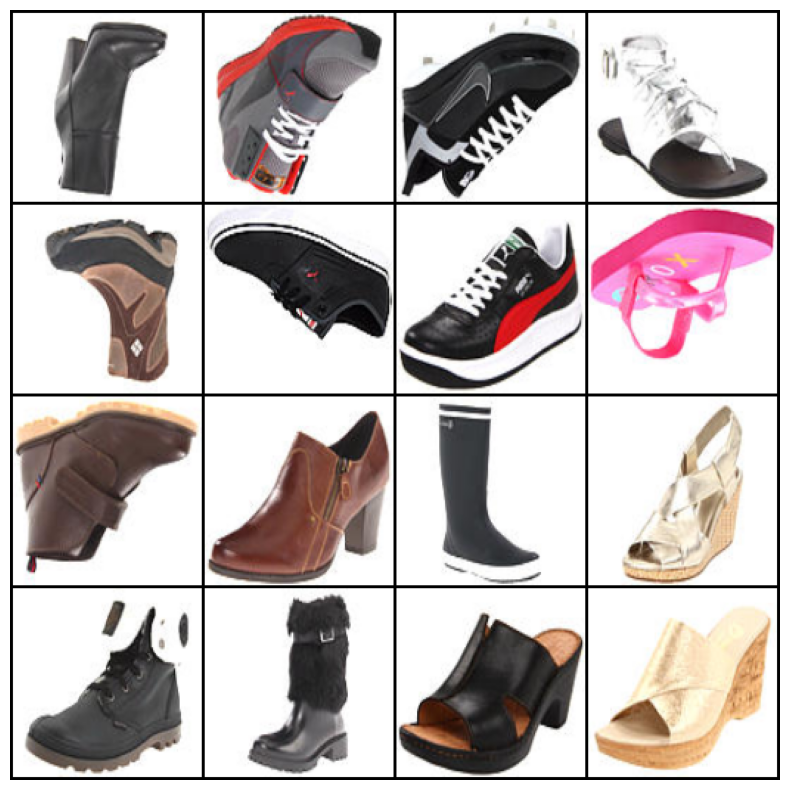

In [ ]:
#kiểm tra ảnh đã được làm giàu
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Tạo ra một lưới ảnh với kích thước 4x4
batch = next(iter(train_loader))
images = batch[0][:16]
grid_image = vutils.make_grid(images, nrow=4, padding=2, normalize=True)

# Chuyển đổi tensor sang numpy array và hiển thị bằng matplotlib
plt.figure(figsize=(10,10))
plt.imshow(grid_image.permute(1,2,0))
plt.axis("off")
plt.show()


# Built model

In [ ]:
# Ma trận(m*n), kernel(k*k), stride = s, padding = p => kích thước ma trận ra: (((m-k+2p)/s)+1))*(((n-k+2p)/s)+1))       


In [ ]:
#tạo mô hình huấn luyện 
from torch import nn

# building model
class Model(nn.Module):
    def __init__(self, input_shape: int, out_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, 16, 3), #126 126
            nn.ReLU(),
            nn.Conv2d(16, 32, 3), #124 124
            nn.ReLU(),
            nn.MaxPool2d(2) # 62 62
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # 60 60
            nn.Conv2d(64, 128, 3), # 58 58
            nn.ReLU(),
            nn.MaxPool2d(2) # 29 29
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*29*29, 512),
            nn.Linear(512, 64),
            nn.Linear(64, out_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [ ]:
#lựa chọn cpu or gpu
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
#chạy model theo chế độ đã định trước đó
model = Model(3, 3).to(device)

In [ ]:
#sử dụng hàm summary để trực quan mô hình 
from prompt_toolkit.shortcuts.progress_bar.base import E
# show cnn use torchinfo
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[32, 3, 128, 128])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 62, 62]          --
│    └─Conv2d: 2-1                       [32, 16, 126, 126]        448
│    └─ReLU: 2-2                         [32, 16, 126, 126]        --
│    └─Conv2d: 2-3                       [32, 32, 124, 124]        4,640
│    └─ReLU: 2-4                         [32, 32, 124, 124]        --
│    └─MaxPool2d: 2-5                    [32, 32, 62, 62]          --
├─Sequential: 1-2                        [32, 128, 29, 29]         --
│    └─Conv2d: 2-6                       [32, 64, 60, 60]          18,496
│    └─Conv2d: 2-7                       [32, 128, 58, 58]         73,856
│    └─ReLU: 2-8                         [32, 128, 58, 58]         --
│    └─MaxPool2d: 2-9                    [32, 128, 29, 29]         --
├─Sequential: 1-3                        [32, 3]                   --
│  

# Train model

In [ ]:
# training
def train_step(model: torch.nn.Module,
               dataset: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
      # setup train loss, acc
      train_loss, train_acc = 0, 0

      # put model into mode train
      model.train()

      # loop
      for batch, (X, y) in enumerate(dataset):
          #send X, y to device
          X, y = X.to(device), y.to(device)

          # 1. Forward
          y_pred = model(X)

          # 2. calculate loss
          loss = loss_fn(y_pred, y)
          train_loss += loss.item()

          # 3. optimizer zero grad
          optimizer.zero_grad()

          # 4. backward
          loss.backward()

          # 5. update the optim
          optimizer.step()

          y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
          train_acc += ((y_pred_class == y).sum().item()) / len(y_pred)
      
      # adjust metric
      train_loss = train_loss / len(dataset)
      train_acc = train_acc / len(dataset)
      return train_loss, train_acc

In [ ]:
# testing
def test_step(model: torch.nn.Module,
              dataset: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module
              ):
  
    # setup test loss, acc
    test_loss, test_acc = 0, 0

    # put model into eval
    model.eval()

    # loop
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataset):
            # send X, y to device
            X, y = X.to(device), y.to(device)

            # 1. forward
            test_pred = model(X)

            # 2. calculate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = torch.argmax(torch.softmax(test_pred, dim = 1), dim=1)
            test_acc += ((test_pred_class == y).sum().item()) / len(test_pred)

        #adiust metric
        test_loss = test_loss / len(dataset)
        test_acc = test_acc / len(dataset)
        return test_loss, test_acc

In [ ]:
# ket hop train_step voi test_step
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int):

    # setup results
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    torch.manual_seed(42)

    best_test_acc = 0.0
    best_weights = None
    # loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataset=train_loader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_acc = test_step(model=model, dataset=test_loader, loss_fn=loss_fn)

        print(f'Epoch: {epoch+1}')
        print(f'Train_loss: {train_loss:.4f}')
        print(f'Train_acc: {train_acc:.2f}')
        print(f'Test_loss: {test_loss:.4f}')
        print(f'Test_acc: {test_acc:.2f}')

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        if test_acc > best_test_acc:
          best_test_acc = test_acc
          best_weights = model.state_dict()
    torch.save(best_weights, 'best_model_weights.pth')      
    return results
     

# Training

In [ ]:
#thiết lập epochs, loss_fn, optimizer để tiến hành training
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model_results = train(model=model, train_dataloader=train_loader, test_dataloader=test_loader,
                      loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train_loss: 0.7152
Train_acc: 0.70
Test_loss: 0.4164
Test_acc: 0.83
Epoch: 2
Train_loss: 0.4134
Train_acc: 0.83
Test_loss: 0.3767
Test_acc: 0.86
Epoch: 3
Train_loss: 0.3543
Train_acc: 0.86
Test_loss: 0.3192
Test_acc: 0.88
Epoch: 4
Train_loss: 0.3157
Train_acc: 0.88
Test_loss: 0.2905
Test_acc: 0.89
Epoch: 5
Train_loss: 0.2695
Train_acc: 0.90
Test_loss: 0.2564
Test_acc: 0.90


# Kiểm tra model

In [ ]:
# plot 
from typing import Tuple, Dict, List
def plot_loss_acc(results: Dict[str, List[float]]):

    # get the loss
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # get the acc
    train_acc = results['train_acc']
    test_acc = results['test_acc']

    epochs = range(len(results['train_loss']))

    # setup figure
    plt.figure(figsize=(15, 7))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # plot acc
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='train_acc')
    plt.plot(epochs, test_acc, label='test_acc')
    plt.title('Acc')
    plt.xlabel('Epochs')
    plt.legend();
    
     

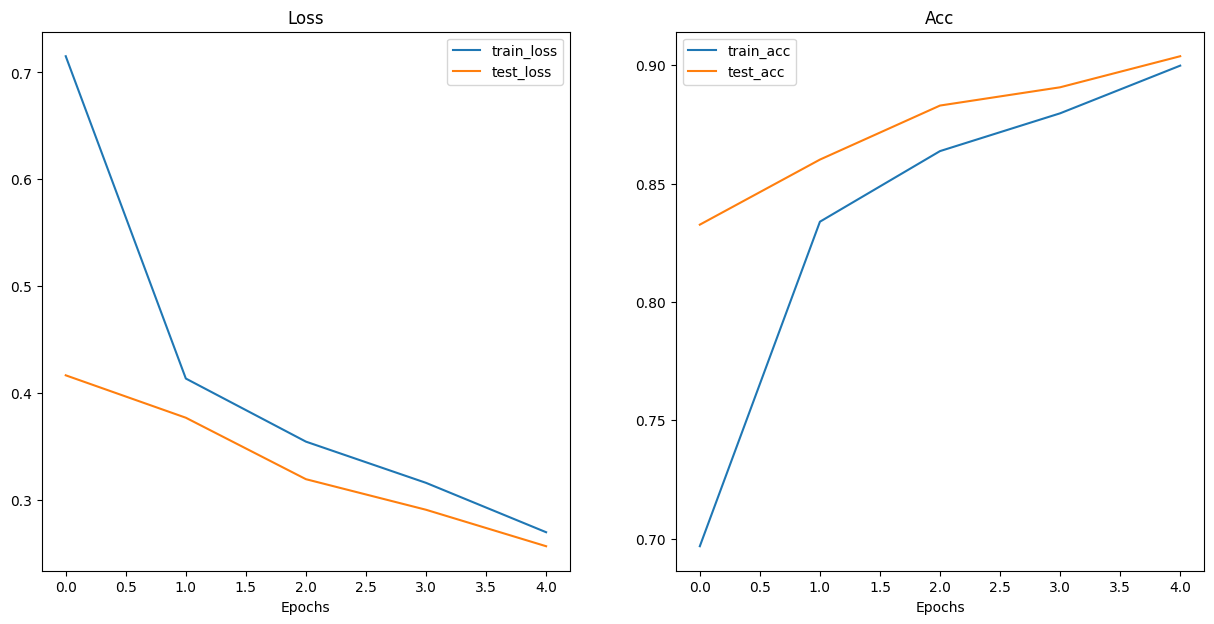

In [ ]:
plot_loss_acc(model_results)

In [ ]:
#dự đoán ảnh và đưa ra thời gian infer
import time
model = model.to('cuda:0')
target_img = torchvision.io.read_image(str('/content/dataset/test/Sandal/4500.jpg')).type(torch.float32)
transform_pred = transforms.Compose([
    transforms.Resize((128, 128))
])

target_img = target_img/255
target_img = transform_pred(target_img)
model.eval()
start = time.time()
with torch.inference_mode():
    # them mot kic thuoc bo sung cho anh
    target_img = target_img.unsqueeze(dim=0)
    

    # make pred
    img_pred = model(target_img.to(device))
    # img_pred = model(target_img)

# 6. convert logist
img_pred_prob = torch.softmax(img_pred, dim=1)

import numpy as np
idx = torch.argmax(img_pred_prob, dim=1)
end = time.time()
time1 = np.round((end-start) * 1000, 2)

print('Final top pred: ' + class_name[idx])
print('Time: ' + str(time1) + ' ms')
plt.imshow(target_img.squeeze().permute(1,2,0))